# Run MetaDetect on IMCOM

In [1]:
import os
from copy import deepcopy
import time
import joblib
from tqdm.notebook import tqdm
import s3fs

import numpy as np

from astropy.io import fits

import galsim

import ngmix
import metadetect

In [2]:
import matplotlib.pyplot as plt

### Genera config for Metadetect

In [3]:
# Size of the taget Gaussian PSF in IMCOM
PSF_FWHM = {
    "Y106": 0.22,
    "J129": 0.231,
    "H158": 0.242,
    "F184": 0.253,
    "K213": 0.264,
}
# Size of the image used to draw the PSF
PSF_IMG_SIZE = 151

# Size of one IMCOM block
IMG_SIZE = 2688
# Boundary used to avoid edge effects
# Objects for which the centre is within this distance from the edge will be
# masked out.
BOUND_SIZE = 100

METADETECT_CONFIG = {
    # Shape measurement method
    # wmom: weighted moments
    "model": "wmom",

    # Size of the weight function for the moments
    'weight': {
        'fwhm': 1.2,  # arcsec
    },

    # Metacal settings
    'metacal': {
        'psf': 'fitgauss',
        # Kind of shear applied to the image
        'types': ['noshear', '1p', '1m', '2p', '2m'],
    },

    'sx': {
        # in sky sigma
        # DETECT_THRESH
        'detect_thresh': 0.8,

        # Minimum contrast parameter for deblending
        # DEBLEND_MINCONT
        'deblend_cont': 0.00001,

        # minimum number of pixels above threshold
        # DETECT_MINAREA: 6
        'minarea': 4,

        'filter_type': 'conv',

        # 7x7 convolution mask of a gaussian PSF with FWHM = 3.0 pixels.
        'filter_kernel': [
            [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],  # noqa
            [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],  # noqa
            [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],  # noqa
            [0.068707, 0.296069, 0.710525, 0.951108, 0.710525, 0.296069, 0.068707],  # noqa
            [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],  # noqa
            [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],  # noqa
            [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],  # noqa
        ]
    },

    # This is for the cutout at each detection
    'meds': {
        'min_box_size': 32,
        'max_box_size': 32,

        'box_type': 'iso_radius',

        'rad_min': 4,
        'rad_fac': 2,
        'box_padding': 2,
    },

    # check for an edge hit
    'bmask_flags': 2**30,

    'nodet_flags': 2**0,
}

### Set of funtions used to get the multiplicative bias

They are taken from:
- metadetect: https://github.com/esheldon/metadetect/blob/master/shear_meas_test/test_shear_meas.py
- descwl-shear-sims: https://github.com/LSSTDESC/descwl-shear-sims/blob/master/shear_meas_tests/test_shear_meas.py

They have been modified to apply th eshear conceltion from IMCOM layers:
$$
\frac{\partial e_{1}}{\partial g_{1}} = m_{1} = \frac{2 \times \rm{layer7} - \rm{layer8} - \rm{layer9}}{3 \times 0.02}
$$
$$
\frac{\partial e_{2}}{\partial g_{2}} = m_{2} = \frac{\rm{layer8} - \rm{layer9}}{\sqrt{3} \times 0.02}
$$
We can also get the additive bias:
$$
c_{2} = \frac{\rm{layer8} + \rm{layer9}}{2}
$$

In [4]:
def _shear_cuts(arr, model):
    """
    Apply selection cuts + remove objects close to the edge.
    """
    if model == "wmom":
        tmin = 1.2
    else:
        tmin = 0.5

    buff_mask = (
        (arr["sx_col"] > BOUND_SIZE)
        & (arr["sx_col"] < IMG_SIZE-BOUND_SIZE) 
        & (arr["sx_row"] > BOUND_SIZE) 
        & (arr["sx_row"] < IMG_SIZE-BOUND_SIZE)
    )
    msk = (
        (arr[f'{model}_flags'] == 0)
        & (arr[f'{model}_s2n'] > 10)
        & (arr[f'{model}_T_ratio'] > tmin)
        & buff_mask
    )
    return msk

In [5]:
def _meas_shear_data(res, model):
    """
    Measure the shear response.
    """
    msk = _shear_cuts(res['noshear'], model)
    g1 = np.mean(res['noshear'][f'{model}_g'][msk, 0])
    g2 = np.mean(res['noshear'][f'{model}_g'][msk, 1])

    msk = _shear_cuts(res['1p'], model)
    g1_1p = np.mean(res['1p'][f'{model}_g'][msk, 0])
    msk = _shear_cuts(res['1m'], model)
    g1_1m = np.mean(res['1m'][f'{model}_g'][msk, 0])
    R11 = (g1_1p - g1_1m) / 0.02

    msk = _shear_cuts(res['2p'], model)
    g2_2p = np.mean(res['2p'][f'{model}_g'][msk, 1])
    msk = _shear_cuts(res['2m'], model)
    g2_2m = np.mean(res['2m'][f'{model}_g'][msk, 1])
    R22 = (g2_2p - g2_2m) / 0.02

    dt = [
        ('g1', 'f8'),
        ('g2', 'f8'),
        ('R11', 'f8'),
        ('R22', 'f8')]
    return np.array([(g1, g2, R11, R22)], dtype=dt)

In [6]:
def _bootstrap_stat(d1, d2, d3, func, seed, nboot=500):
    """
    Bootstrap data to get mean m-bias and associated error.
    """
    dim = d1.shape[0]
    rng = np.random.RandomState(seed=seed)
    stats = []
    for _ in range(nboot):
        ind = rng.choice(dim, size=dim, replace=True)
        stats.append(func(d1[ind], d2[ind], d3[ind]))
    return stats

In [7]:
def meas_m_c_cancel(res7, res8, res9):
    x = np.mean(2*res7['g1'] - res8['g1'] - res9['g1'])/3
    y = np.mean(res7['R11'] + res8['R11'] + res9['R11'])/3
    m1 = x/y/0.02 - 1

    x = np.mean(res8["g2"] - res9["g2"])/np.sqrt(3)
    y = np.mean(res8['R22'] + res9['R22'])/2
    m2 = x/y/0.02 - 1

    x = np.mean(res8['g2'] + res9['g2'])/2
    y = np.mean(res8['R22'] + res9['R22'])/2
    c = x/y

    return m1, m2, c

In [8]:
def boostrap_m_c(res7, res8, res9):
    m1, m2, c = meas_m_c_cancel(res7, res8, res9)
    bdata = _bootstrap_stat(res7, res8, res9, meas_m_c_cancel, 14324, nboot=500)
    m1err, m2err, cerr = np.std(bdata, axis=0)
    return m1, m1err, m2, m2err, c, cerr

In [9]:
def run_sim(img_path, seed, mdet_seed, model, band="H158"):
    """
    Recover the IMCOM image from `aws` and run metadection.
    """
    rng = np.random.RandomState(seed=seed)
    cfg = deepcopy(METADETECT_CONFIG)
    cfg["model"] = model
    
    # Read image
    with fits.open("s3://" + img_path, fsspec_kwargs={"anon": True}) as hdul:
        f = hdul[0].section[0, 7:10]
        h = hdul[0].header

    # Make WCS
    h.pop("NAXIS3")
    h.pop("NAXIS4")
    h["NAXIS"] = 2
    w = galsim.AstropyWCS(header=h)
    img_jacobian = w.jacobian(image_pos=galsim.PositionD(h["CRPIX1"], h["CRPIX2"]))

    # Make noise
    noise_sigma = 1e-4
    noise = rng.normal(size=(IMG_SIZE, IMG_SIZE)) * noise_sigma

    # Make PSF
    psf = galsim.Gaussian(fwhm=PSF_FWHM[band])
    psf_img = psf.drawImage(
        nx=PSF_IMG_SIZE,
        ny=PSF_IMG_SIZE,
        wcs=w,
    ).array

    # Make NGmix jacobian
    psf_cen = (PSF_IMG_SIZE - 1) / 2
    img_cen = (np.array([IMG_SIZE, IMG_SIZE]) - 1) / 2

    psf_jac = ngmix.Jacobian(
        row=psf_cen,
        col=psf_cen,
        wcs=img_jacobian,
    )
    img_jac = ngmix.Jacobian(
        row=img_cen[0],
        col=img_cen[1],
        wcs=img_jacobian,
    )

    # Make PSF observation
    psf_obs = ngmix.Observation(
        image=psf_img,
        jacobian=psf_jac,
    )

    # Make obs
    res_layers = []
    for i in range(3):
        obs = ngmix.Observation(
            image=f[0 + i] + noise,
            jacobian=img_jac,
            weight=np.ones((IMG_SIZE, IMG_SIZE), dtype=float) / noise_sigma**2,
            psf=psf_obs,
            ormask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
            bmask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
        )

        obslist = ngmix.ObsList()
        obslist.append(obs)
        mbobs = ngmix.MultiBandObsList()
        mbobs.append(obslist)

        res = metadetect.do_metadetect(
            deepcopy(cfg),
            mbobs=mbobs,
            rng=np.random.RandomState(seed=mdet_seed),
        )
        res_layers.append(res)

    return _meas_shear_data(res_layers[0], model), _meas_shear_data(res_layers[1], model), _meas_shear_data(res_layers[2], model)


# Check an image

In [10]:
# Setup the filesystem
fs = s3fs.S3FileSystem(anon=True)

In [11]:
# Path to the IMCOM coadds on AWS S3
coadd_dir = "nasa-irsa-simulations/openuniverse2024/roman/preview/RomanWAS/images/coadds"

In [12]:
band = "H158"

In [13]:
band_dir = os.path.join(coadd_dir, band)

In [14]:
subdirs = fs.ls(band_dir)

In [15]:
row_ind = 0
img_dir = subdirs[row_ind]

In [16]:
imgs = fs.ls(img_dir)

In [17]:
# Read an image and load only the layers we need
with fits.open("s3://" + imgs[1], fsspec_kwargs={"anon": True}) as hdul:
    f = hdul[0].section[0, 7:10]
    h = hdul[0].header

In [18]:
h.pop("NAXIS3")
h.pop("NAXIS4")
h["NAXIS"] = 2
w = galsim.AstropyWCS(header=h)

In [19]:
img_jacobian = w.jacobian(image_pos=galsim.PositionD(h["CRPIX1"], h["CRPIX2"]))

In [20]:
rng = np.random.RandomState(42)
noise_sigma = 1e-4
noise = rng.normal(size=(IMG_SIZE, IMG_SIZE)) * noise_sigma

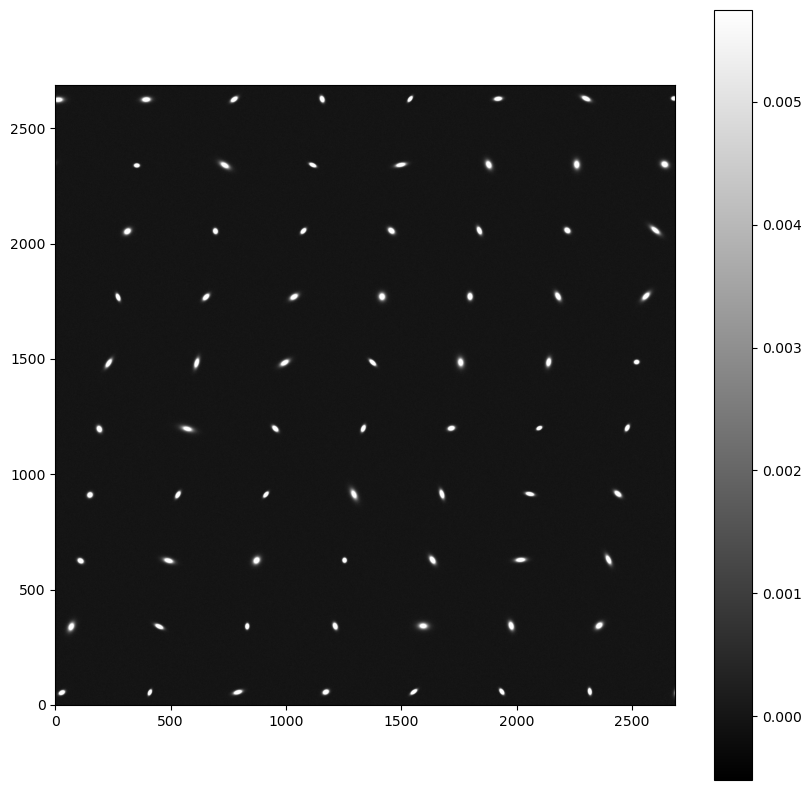

In [21]:
plt.figure(figsize=(10, 10))
img = f[0] + noise
m_img = np.mean(img)
s_img = np.std(img)
plt.imshow(img, origin='lower', cmap='gray', vmin=max(np.min(img), m_img - 5 * s_img), vmax=m_img + 5 * s_img)
plt.colorbar()

In [22]:
psf = galsim.Gaussian(fwhm=PSF_FWHM[band])
psf_img = psf.drawImage(
    nx=PSF_IMG_SIZE,
    ny=PSF_IMG_SIZE,
    wcs=w,
).array

In [23]:
psf_cen = (PSF_IMG_SIZE - 1) / 2
img_cen = (np.array([IMG_SIZE, IMG_SIZE]) - 1) / 2

psf_jac = ngmix.Jacobian(
    row=psf_cen,
    col=psf_cen,
    wcs=img_jacobian,
)
img_jac = ngmix.Jacobian(
    row=img_cen[0],
    col=img_cen[1],
    wcs=img_jacobian,
)

psf_obs = ngmix.Observation(
    image=psf_img,
    jacobian=psf_jac,
)

obs = ngmix.Observation(
    image=f[0] + noise,
    jacobian=img_jac,
    weight=np.ones((IMG_SIZE, IMG_SIZE), dtype=float) / noise_sigma**2,
    psf=psf_obs,
    ormask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
    bmask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
)

obslist = ngmix.ObsList()
obslist.append(obs)
mbobs = ngmix.MultiBandObsList()
mbobs.append(obslist)

In [24]:
res = metadetect.do_metadetect(
    deepcopy(METADETECT_CONFIG),
    mbobs=mbobs,
    rng=np.random.RandomState(42),
)

In [25]:
res["noshear"].size

90

In [26]:
buff_mask = (res["noshear"]["sx_col"] > BOUND_SIZE) & (res["noshear"]["sx_col"] < IMG_SIZE-BOUND_SIZE) & \
            (res["noshear"]["sx_row"] > BOUND_SIZE) & (res["noshear"]["sx_row"] < IMG_SIZE-BOUND_SIZE)
m_good = (res["noshear"]["wmom_s2n"] > 10) & (res["noshear"]["wmom_T_ratio"] > 0.5) & (res["noshear"]["wmom_flags"] == 0) & buff_mask

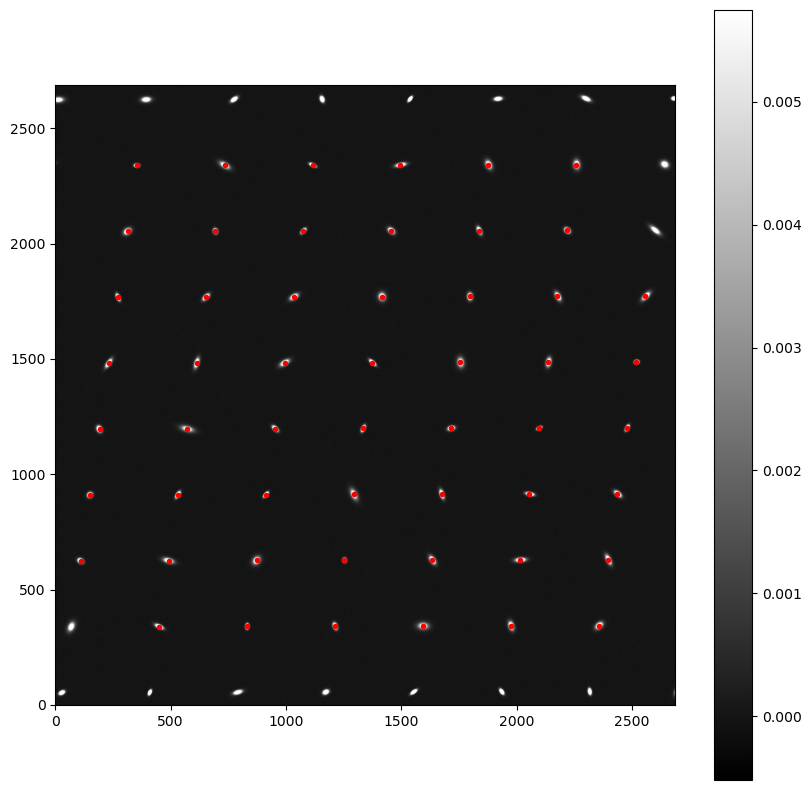

In [27]:
plt.figure(figsize=(10, 10))
img = f[0] + noise
m_img = np.mean(img)
s_img = np.std(img)
plt.imshow(img, origin='lower', cmap='gray', vmin=max(np.min(img), m_img - 5 * s_img), vmax=m_img + 5 * s_img)
plt.plot(res["noshear"]["sx_col"][m_good], res["noshear"]["sx_row"][m_good], "r.")
plt.colorbar()

# Process all preview

In [28]:
all_img_paths = []
for subdir in subdirs:
    all_img_paths += fs.ls(subdir)

In [29]:
run_sim(all_img_paths[0], seed=42, mdet_seed=42, model="wmom", band=band)

(array([(-0.01047459, 0.01226554, 0.8499439, 0.98113245)],
       dtype=[('g1', '<f8'), ('g2', '<f8'), ('R11', '<f8'), ('R22', '<f8')]),
 array([(-0.03534738, 0.02819482, 0.84890712, 0.98209083)],
       dtype=[('g1', '<f8'), ('g2', '<f8'), ('R11', '<f8'), ('R22', '<f8')]),
 array([(-0.03619065, -0.00596436, 0.84770537, 0.98328118)],
       dtype=[('g1', '<f8'), ('g2', '<f8'), ('R11', '<f8'), ('R22', '<f8')]))

In [30]:
model = "wmom"
ntrial = len(all_img_paths)
# nsub = max(ntrial // 100, 10)
nsub = 16
nitr = ntrial // nsub
rng = np.random.RandomState(seed=116)
seeds = rng.randint(low=1, high=2**29, size=ntrial)
mdet_seeds = rng.randint(low=1, high=2**29, size=ntrial)

tm0 = time.time()

print("")

res7 = []
res8 = []
res9 = []
loc = 0
for itr in tqdm(range(nitr), total=nitr):
    jobs = [
        joblib.delayed(run_sim)(
            all_img_paths[loc+i],seeds[loc+i], mdet_seeds[loc+i], model,
        )
        for i in range(nsub)
    ]
    outputs = joblib.Parallel(n_jobs=-1, verbose=0, backend='loky')(jobs)

    for out in outputs:
        if out is None:
            continue
        res7.append(out[0])
        res8.append(out[1])
        res9.append(out[2])
    loc += nsub

    m1, m1err, m2, m2err, c, cerr = boostrap_m_c(
        np.concatenate(res7),
        np.concatenate(res8),
        np.concatenate(res9),
    )
    print(
        (
            "\n"
            "nsims: %d\n"
            "m1 [1e-3, 3sigma]: %s +/- %s\n"
            "m2 [1e-3, 3sigma]: %s +/- %s\n"
            "c [1e-5, 3sigma]: %s +/- %s\n"
            "\n"
        ) % (
            len(res7),
            m1/1e-3,
            3*m1err/1e-3,
            m2/1e-3,
            3*m2err/1e-3,
            c/1e-5,
            3*cerr/1e-5,
        ),
        flush=True,
    )

total_time = time.time()-tm0
print("time per:", total_time/ntrial, flush=True)

  0%|          | 0/9 [00:00<?, ?it/s]


nsims: 16
m1 [1e-3, 3sigma]: -18.109637868460315 +/- 188.45086372385788
m2 [1e-3, 3sigma]: 27.27256638216824 +/- 149.18960349369235
c [1e-5, 3sigma]: 767.4235048161958 +/- 2977.9944991713937



nsims: 32
m1 [1e-3, 3sigma]: -45.53932341308142 +/- 155.50824765183145
m2 [1e-3, 3sigma]: 59.97651690626671 +/- 106.12273637284342
c [1e-5, 3sigma]: 1711.1087877075806 +/- 2233.29392619711



nsims: 48
m1 [1e-3, 3sigma]: -25.64025157103378 +/- 159.91917674923045
m2 [1e-3, 3sigma]: 14.476818117035384 +/- 110.4286818459892
c [1e-5, 3sigma]: 373.09076624932794 +/- 1835.7427711745656



nsims: 64
m1 [1e-3, 3sigma]: -30.39715116215702 +/- 146.23926754463264
m2 [1e-3, 3sigma]: 33.49537040256201 +/- 113.35099340259298
c [1e-5, 3sigma]: -27.933028647829108 +/- 1496.8348201966944




/Users/aguinot/miniconda3/envs/roman_sim/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



nsims: 80
m1 [1e-3, 3sigma]: -8.657798257084126 +/- 118.0337925804174
m2 [1e-3, 3sigma]: 30.801655897183977 +/- 92.36029741572084
c [1e-5, 3sigma]: -0.5561685796220466 +/- 1317.1309325532925



nsims: 96
m1 [1e-3, 3sigma]: 9.194399002939502 +/- 109.64056305266945
m2 [1e-3, 3sigma]: 16.158073912374782 +/- 78.2417893532744
c [1e-5, 3sigma]: -139.23969064791464 +/- 1199.4944444166258



nsims: 112
m1 [1e-3, 3sigma]: 10.91630202703886 +/- 97.31025100200263
m2 [1e-3, 3sigma]: 10.30253837256212 +/- 70.16399399275792
c [1e-5, 3sigma]: -257.77971085936554 +/- 1074.872347154749



nsims: 128
m1 [1e-3, 3sigma]: 17.87633450371473 +/- 92.77965542211469
m2 [1e-3, 3sigma]: 17.471350236955896 +/- 63.31733905058059
c [1e-5, 3sigma]: -174.60203231394323 +/- 961.7293021739196



nsims: 144
m1 [1e-3, 3sigma]: 18.293902449402655 +/- 81.34423102456535
m2 [1e-3, 3sigma]: 18.55417939686643 +/- 58.740234306890656
c [1e-5, 3sigma]: -117.96509366192161 +/- 969.6492652776494


time per: 24.782809381683666


In [31]:
res7 = np.concatenate(res7)
res8 = np.concatenate(res8)
res9 = np.concatenate(res9)
m1, m1err, m2, m2err, c, cerr = boostrap_m_c(
    res7,
    res8,
    res9,
)
print(
    (
        "\n"
        "nsims: %d\n"
        "m1 [1e-3, 3sigma]: %s +/- %s\n"
        "m2 [1e-3, 3sigma]: %s +/- %s\n"
        "c [1e-5, 3sigma]: %s +/- %s\n"
        "\n"
    ) % (
        len(res7),
        m1/1e-3,
        3*m1err/1e-3,
        m2/1e-3,
        3*m2err/1e-3,
        c/1e-5,
        3*cerr/1e-5,
    ),
    flush=True,
)


nsims: 144
m1 [1e-3, 3sigma]: 18.293902449402655 +/- 81.34423102456535
m2 [1e-3, 3sigma]: 18.55417939686643 +/- 58.740234306890656
c [1e-5, 3sigma]: -117.96509366192161 +/- 969.6492652776494


